In [23]:
import os, sys
sys.path.insert(1, '../')

from importlib import reload
from tqdm import tqdm
from time import time

import numpy as np
import pandas as pd

import utils

import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
native_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
native_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


In [39]:
reload(utils)
n_trial = 1000
qs = [0.25, 0.5, 0.75]
ns = np.logspace(np.log10(50), np.log10(2000), num=10, base=10).astype(int)[::-1]
alpha = 0.1
n_train = 5
theta_grid_spacing = 0.01
save = True
save_fname = 'iid-clt-results-011722.csv'

y_all = native_df.measured.to_numpy()
f_all = native_df.predicted.to_numpy()

columns = ['q', 'n', 'width', 'covered', 'estimator', 'lower', 'upper']
results = []
for q_idx, q in enumerate(qs):
    for n_idx, n in enumerate(ns):
        for _ in tqdm(range(n_trial)):
            
            q_true, ci_pp, ci_cl  = utils.get_quantile_intervals(
                y_all, f_all, q, n, alpha, n_train=n_train, theta_grid_spacing=theta_grid_spacing
            )
            cov_cl = (ci_cl[0] <= q_true) & (ci_cl[1] >= q_true)
            cov_pp = (ci_pp[0] <= q_true) & (ci_pp[1] >= q_true)
            results.append([q, n, ci_pp[1] - ci_pp[0], int(cov_pp), 'prediction-powered', ci_pp[0], ci_pp[1]])
            results.append([q, n, ci_cl[1] - ci_cl[0], int(cov_cl), 'classical', ci_cl[0], ci_cl[1]])
            
        df = pd.DataFrame(results, columns=columns)
        if save:
            df.to_csv(save_fname)
        
        print('n = {}, q = {}'.format(n, q))
        print('  avg. classical width: {:.2f}, avg. PP width: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].width.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].width.mean()
        ))
        print('  avg. classical cov: {:.2f}, avg. PP cov: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].covered.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].covered.mean()
        ))

100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s]


n = 2000, q = 0.25
  avg. classical width: 0.24, avg. PP width: 0.19
  avg. classical cov: 0.90, avg. PP cov: 0.89


100%|██████████| 1000/1000 [07:19<00:00,  2.27it/s]


n = 1327, q = 0.25
  avg. classical width: 0.29, avg. PP width: 0.24
  avg. classical cov: 0.91, avg. PP cov: 0.89


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


n = 881, q = 0.25
  avg. classical width: 0.36, avg. PP width: 0.29
  avg. classical cov: 0.91, avg. PP cov: 0.90


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


n = 584, q = 0.25
  avg. classical width: 0.45, avg. PP width: 0.37
  avg. classical cov: 0.91, avg. PP cov: 0.92


100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]


n = 388, q = 0.25
  avg. classical width: 0.54, avg. PP width: 0.45
  avg. classical cov: 0.91, avg. PP cov: 0.93


100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


n = 257, q = 0.25
  avg. classical width: 0.68, avg. PP width: 0.56
  avg. classical cov: 0.91, avg. PP cov: 0.91


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


n = 170, q = 0.25
  avg. classical width: 0.86, avg. PP width: 0.72
  avg. classical cov: 0.92, avg. PP cov: 0.93


100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


n = 113, q = 0.25
  avg. classical width: 1.03, avg. PP width: 0.89
  avg. classical cov: 0.92, avg. PP cov: 0.94


100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


n = 75, q = 0.25
  avg. classical width: 1.34, avg. PP width: 1.13
  avg. classical cov: 0.90, avg. PP cov: 0.94


100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


n = 49, q = 0.25
  avg. classical width: 1.79, avg. PP width: 1.40
  avg. classical cov: 0.92, avg. PP cov: 0.94


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


n = 2000, q = 0.5
  avg. classical width: 0.56, avg. PP width: 0.31
  avg. classical cov: 0.89, avg. PP cov: 0.90


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


n = 1327, q = 0.5
  avg. classical width: 0.69, avg. PP width: 0.37
  avg. classical cov: 0.91, avg. PP cov: 0.90


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


n = 881, q = 0.5
  avg. classical width: 0.85, avg. PP width: 0.46
  avg. classical cov: 0.90, avg. PP cov: 0.92


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


n = 584, q = 0.5
  avg. classical width: 1.05, avg. PP width: 0.57
  avg. classical cov: 0.92, avg. PP cov: 0.91


100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


n = 388, q = 0.5
  avg. classical width: 1.30, avg. PP width: 0.72
  avg. classical cov: 0.92, avg. PP cov: 0.93


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


n = 257, q = 0.5
  avg. classical width: 1.61, avg. PP width: 0.89
  avg. classical cov: 0.92, avg. PP cov: 0.93


100%|██████████| 1000/1000 [06:42<00:00,  2.49it/s]


n = 170, q = 0.5
  avg. classical width: 2.03, avg. PP width: 1.11
  avg. classical cov: 0.90, avg. PP cov: 0.95


100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]


n = 113, q = 0.5
  avg. classical width: 2.46, avg. PP width: 1.45
  avg. classical cov: 0.91, avg. PP cov: 0.95


100%|██████████| 1000/1000 [06:12<00:00,  2.69it/s]


n = 75, q = 0.5
  avg. classical width: 2.98, avg. PP width: 1.86
  avg. classical cov: 0.91, avg. PP cov: 0.95


100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


n = 49, q = 0.5
  avg. classical width: 3.72, avg. PP width: 2.46
  avg. classical cov: 0.90, avg. PP cov: 0.96


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


n = 2000, q = 0.75
  avg. classical width: 0.61, avg. PP width: 0.36
  avg. classical cov: 0.92, avg. PP cov: 0.92


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


n = 1327, q = 0.75
  avg. classical width: 0.76, avg. PP width: 0.45
  avg. classical cov: 0.92, avg. PP cov: 0.94


100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


n = 881, q = 0.75
  avg. classical width: 0.95, avg. PP width: 0.54
  avg. classical cov: 0.92, avg. PP cov: 0.91


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


n = 584, q = 0.75
  avg. classical width: 1.16, avg. PP width: 0.67
  avg. classical cov: 0.91, avg. PP cov: 0.92


100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


n = 388, q = 0.75
  avg. classical width: 1.40, avg. PP width: 0.82
  avg. classical cov: 0.90, avg. PP cov: 0.91


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


n = 257, q = 0.75
  avg. classical width: 1.76, avg. PP width: 1.02
  avg. classical cov: 0.92, avg. PP cov: 0.92


100%|██████████| 1000/1000 [06:45<00:00,  2.46it/s]


n = 170, q = 0.75
  avg. classical width: 2.25, avg. PP width: 1.31
  avg. classical cov: 0.90, avg. PP cov: 0.93


100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


n = 113, q = 0.75
  avg. classical width: 2.90, avg. PP width: 1.68
  avg. classical cov: 0.91, avg. PP cov: 0.95


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


n = 75, q = 0.75
  avg. classical width: 3.64, avg. PP width: 2.17
  avg. classical cov: 0.94, avg. PP cov: 0.94


100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


n = 49, q = 0.75
  avg. classical width: 4.39, avg. PP width: 2.91
  avg. classical cov: 0.93, avg. PP cov: 0.95


## plot comparison of interval widths

In [40]:
df = pd.read_csv('iid-clt-results-011722.csv', index_col=0)
df

,q,n,width,covered,estimator,lower,upper
0,0.25,2000,0.210000,1,prediction-powered,2.864698,3.074698
1,0.25,2000,0.211692,1,classical,2.772702,2.984394
2,0.25,2000,0.200000,1,prediction-powered,2.821820,3.021820
3,0.25,2000,0.208788,1,classical,2.819099,3.027887
4,0.25,2000,0.200000,1,prediction-powered,2.886392,3.086392
...,...,...,...,...,...,...,...
59995,0.75,49,5.476777,1,classical,6.037432,11.514209
59996,0.75,49,3.530000,1,prediction-powered,7.139431,10.669431
59997,0.75,49,4.606437,1,classical,6.740266,11.346702
59998,0.75,49,3.580000,1,prediction-powered,9.124217,12.704217


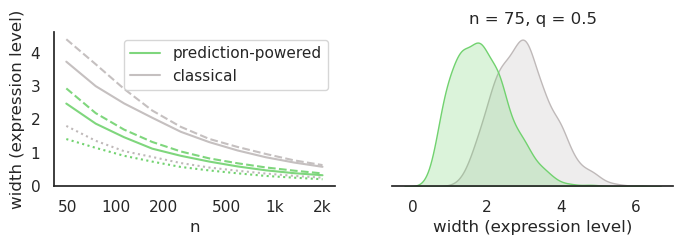

In [42]:
save = True
n_to_plot = 75
plot_df = df.loc[(df.q == 0.5) & (df.n == n_to_plot)]
c_cl, c_pp = "#BFB9B9", "#71D26F"
ns = np.logspace(np.log10(50), np.log10(2000), num=10, base=10).astype(int)
ns_xticks = [50, 100, 200, 500, 1000, 2000]
ns_xticklabels = [50, 100, 200, 500, '1k', '2k']

fig, axs = plt.subplots(1, 2, figsize=(8, 2))
for q, ls in zip([0.25, 0.5, 0.75], [':', '-', '--']):
    dfqn = df.loc[df.q == q]
    wcl_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'classical')].width.mean()for n in ns])
    wpp_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'prediction-powered')].width.mean()for n in ns])
    axs[0].plot(
        ns, wpp_n,
        label='prediction-powered' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_pp)
    axs[0].plot(
        ns, wcl_n,
        label='classical' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_cl)
    
axs[0].set_xscale('log')
axs[0].set_xticks(ns_xticks)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels(ns_xticklabels)
axs[0].set_xlabel('n');
axs[0].set_ylabel('width (expression level)')
axs[0].legend();
sns.despine(ax=axs[0],top=True,right=True)

my_palette = sns.color_palette([c_pp, c_cl], 2)
sns.set_theme(style="white", palette=my_palette)
kde = sns.kdeplot(
    plot_df, x="width", hue="estimator", hue_order=["prediction-powered", "classical"],
    fill=True, ax=axs[1])
kde.get_legend().remove()
sns.despine(ax=axs[1],top=True,right=True,left=True)
axs[1].set_xlabel("width (expression level)")
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title('n = {}, q = 0.5'.format(n_to_plot));
if save:
    plt.savefig('figures/widths.png', dpi=300, bbox_inches='tight')
plt.show()

## plot example set of intervals

/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error in 3.6


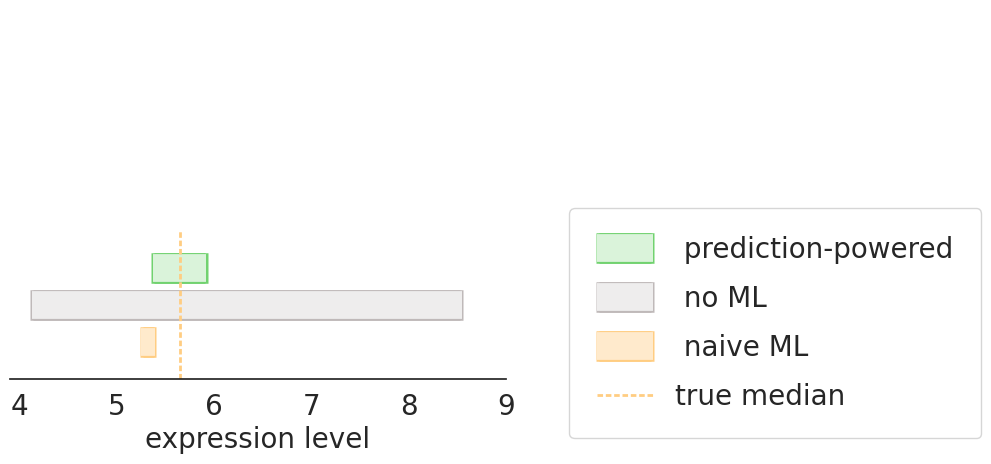

In [45]:
q = 0.5
n = 75
tmp = df.loc[(df.q == q) & (df.n == n)]
cl_df = tmp[1::2]
pp_df = tmp[0::2]
trial = 222
save = True

# true median gene expression
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
theta_star = np.quantile(data_df.measured, 0.5)

# construct naive confidence interval
f_all = data_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))
ci_naive = utils.get_classical_ci(f_all, 0.5, 0.1)

ci_pp = [pp_df.iloc[trial].lower, pp_df.iloc[trial].upper]
ci_cl = [cl_df.iloc[trial].lower, cl_df.iloc[trial].upper]

plt.figure(figsize=(6.4,4.8))
plt.plot(
    ci_pp,[0.3, 0.3],
    linewidth=20, color="#DAF3DA", solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#71D26F"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#71D26F"),
        pe.Normal()
    ],
    label=' prediction-powered'
)
plt.plot(
    ci_cl, [0.2, 0.2],
    linewidth=20, color="#EEEDED",
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#BFB9B9"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#BFB9B9"),
        pe.Normal()
    ],
    label=' no ML'
)
plt.plot(
    ci_naive, [0.1, 0.1],
    linewidth=20, color="#FFEACC", 
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#FFCD82"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#FFCD82"),
        pe.Normal()
    ],
    label=' naive ML'
)
plt.plot(
    [theta_star, theta_star], [0, 0.4], linestyle='--', dashes=(2, 1), linewidth=2,
    label="true median", color="#FFCD82"
)
plt.xlabel("expression level", fontsize=20)
plt.yticks([], labels=[])
plt.xticks(range(4, 10), fontsize=20)
plt.ylim([0,1])
leg = plt.legend(fontsize=20, borderpad=1, labelspacing = 0.75, bbox_to_anchor=[1.1,0.5])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)

if save:
    plt.savefig('./figures/intervals.pdf', ppi=300, bbox_inches='tight')
plt.show()